##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRDPPOG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRDPPOG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRDPPOG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry anout text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

There are three other models to test for the sake of this tutorial:
* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.
* [google/tf2-preview/nnlm-en-dim128/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) - Even larger model with ~1M vocabulary size and 128 dimensions.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 0s - loss: 1.1909 - accuracy: 0.4922

 3/30 [==>...........................] - ETA: 0s - loss: 1.0953 - accuracy: 0.4954

 5/30 [====>.........................] - ETA: 0s - loss: 1.0203 - accuracy: 0.5102

 7/30 [======>.......................] - ETA: 0s - loss: 0.9675 - accuracy: 0.5134

 9/30 [========>.....................] - ETA: 0s - loss: 0.9269 - accuracy: 0.5219

11/30 [==========>...................] - ETA: 0s - loss: 0.8940 - accuracy: 0.5259

13/30 [============>.................] - ETA: 0s - loss: 0.8685 - accuracy: 0.5322

15/30 [==============>...............] - ETA: 0s - loss: 0.8463 - accuracy: 0.5363

17/30 [================>.............] - ETA: 0s - loss: 0.8287 - accuracy: 0.5410

19/30 [==================>...........] - ETA: 0s - loss: 0.8191 - accuracy: 0.5422

21/30 [====================>.........] - ETA: 0s - loss: 0.8112 - accuracy: 0.5443

23/30 [======================>.......] - ETA: 0s - loss: 0.8011 - accuracy: 0.5476

25/30 [========================>.....] - ETA: 0s - loss: 0.7950 - accuracy: 0.5480

27/30 [==========================>...] - ETA: 0s - loss: 0.7876 - accuracy: 0.5487

29/30 [============================>.] - ETA: 0s - loss: 0.7808 - accuracy: 0.5510

30/30 [==============================] - 2s 51ms/step - loss: 0.7801 - accuracy: 0.5512 - val_loss: 0.6930 - val_accuracy: 0.5652


Epoch 2/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6831 - accuracy: 0.5605

 3/30 [==>...........................] - ETA: 0s - loss: 0.6758 - accuracy: 0.5924

 5/30 [====>.........................] - ETA: 0s - loss: 0.6763 - accuracy: 0.5887

 7/30 [======>.......................] - ETA: 0s - loss: 0.6811 - accuracy: 0.5829

 9/30 [========>.....................] - ETA: 0s - loss: 0.6828 - accuracy: 0.5794

11/30 [==========>...................] - ETA: 0s - loss: 0.6769 - accuracy: 0.5836

13/30 [============>.................] - ETA: 0s - loss: 0.6753 - accuracy: 0.5849

15/30 [==============>...............] - ETA: 0s - loss: 0.6725 - accuracy: 0.5872

17/30 [================>.............] - ETA: 0s - loss: 0.6699 - accuracy: 0.5893

19/30 [==================>...........] - ETA: 0s - loss: 0.6678 - accuracy: 0.5925

21/30 [====================>.........] - ETA: 0s - loss: 0.6647 - accuracy: 0.5956

23/30 [======================>.......] - ETA: 0s - loss: 0.6634 - accuracy: 0.5968

25/30 [========================>.....] - ETA: 0s - loss: 0.6625 - accuracy: 0.5980

27/30 [==========================>...] - ETA: 0s - loss: 0.6603 - accuracy: 0.5991

29/30 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6010

30/30 [==============================] - 1s 46ms/step - loss: 0.6584 - accuracy: 0.6015 - val_loss: 0.6439 - val_accuracy: 0.6059


Epoch 3/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6379 - accuracy: 0.5977

 3/30 [==>...........................] - ETA: 0s - loss: 0.6338 - accuracy: 0.6068

 5/30 [====>.........................] - ETA: 0s - loss: 0.6327 - accuracy: 0.6070

 7/30 [======>.......................] - ETA: 0s - loss: 0.6298 - accuracy: 0.6110

 9/30 [========>.....................] - ETA: 0s - loss: 0.6318 - accuracy: 0.6096

11/30 [==========>...................] - ETA: 0s - loss: 0.6293 - accuracy: 0.6113

13/30 [============>.................] - ETA: 0s - loss: 0.6296 - accuracy: 0.6128

15/30 [==============>...............] - ETA: 0s - loss: 0.6288 - accuracy: 0.6167

17/30 [================>.............] - ETA: 0s - loss: 0.6279 - accuracy: 0.6202

19/30 [==================>...........] - ETA: 0s - loss: 0.6265 - accuracy: 0.6204

21/30 [====================>.........] - ETA: 0s - loss: 0.6251 - accuracy: 0.6210

23/30 [======================>.......] - ETA: 0s - loss: 0.6244 - accuracy: 0.6215

25/30 [========================>.....] - ETA: 0s - loss: 0.6234 - accuracy: 0.6246

27/30 [==========================>...] - ETA: 0s - loss: 0.6228 - accuracy: 0.6267

29/30 [============================>.] - ETA: 0s - loss: 0.6223 - accuracy: 0.6282

30/30 [==============================] - 1s 45ms/step - loss: 0.6222 - accuracy: 0.6275 - val_loss: 0.6161 - val_accuracy: 0.6299


Epoch 4/40
 1/30 [>.............................] - ETA: 0s - loss: 0.6066 - accuracy: 0.6465

 3/30 [==>...........................] - ETA: 0s - loss: 0.6055 - accuracy: 0.6432

 5/30 [====>.........................] - ETA: 0s - loss: 0.6039 - accuracy: 0.6398

 7/30 [======>.......................] - ETA: 0s - loss: 0.6031 - accuracy: 0.6445

 9/30 [========>.....................] - ETA: 0s - loss: 0.6007 - accuracy: 0.6471

11/30 [==========>...................] - ETA: 0s - loss: 0.5991 - accuracy: 0.6452

13/30 [============>.................] - ETA: 0s - loss: 0.5973 - accuracy: 0.6480

15/30 [==============>...............] - ETA: 0s - loss: 0.5963 - accuracy: 0.6491

17/30 [================>.............] - ETA: 0s - loss: 0.5981 - accuracy: 0.6468

19/30 [==================>...........] - ETA: 0s - loss: 0.5960 - accuracy: 0.6509

21/30 [====================>.........] - ETA: 0s - loss: 0.5963 - accuracy: 0.6514

23/30 [======================>.......] - ETA: 0s - loss: 0.5963 - accuracy: 0.6506

25/30 [========================>.....] - ETA: 0s - loss: 0.5968 - accuracy: 0.6522

27/30 [==========================>...] - ETA: 0s - loss: 0.5949 - accuracy: 0.6536

29/30 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.6542

30/30 [==============================] - 1s 45ms/step - loss: 0.5939 - accuracy: 0.6544 - val_loss: 0.5908 - val_accuracy: 0.6527


Epoch 5/40
 1/30 [>.............................] - ETA: 0s - loss: 0.5746 - accuracy: 0.6934

 3/30 [==>...........................] - ETA: 0s - loss: 0.5736 - accuracy: 0.6895

 5/30 [====>.........................] - ETA: 0s - loss: 0.5780 - accuracy: 0.6867

 7/30 [======>.......................] - ETA: 0s - loss: 0.5761 - accuracy: 0.6811

 9/30 [========>.....................] - ETA: 0s - loss: 0.5785 - accuracy: 0.6747

11/30 [==========>...................] - ETA: 0s - loss: 0.5761 - accuracy: 0.6760

13/30 [============>.................] - ETA: 0s - loss: 0.5753 - accuracy: 0.6764

15/30 [==============>...............] - ETA: 0s - loss: 0.5751 - accuracy: 0.6763

17/30 [================>.............] - ETA: 0s - loss: 0.5736 - accuracy: 0.6776

19/30 [==================>...........] - ETA: 0s - loss: 0.5755 - accuracy: 0.6758

21/30 [====================>.........] - ETA: 0s - loss: 0.5736 - accuracy: 0.6787

23/30 [======================>.......] - ETA: 0s - loss: 0.5715 - accuracy: 0.6806

25/30 [========================>.....] - ETA: 0s - loss: 0.5689 - accuracy: 0.6814

27/30 [==========================>...] - ETA: 0s - loss: 0.5664 - accuracy: 0.6832

29/30 [============================>.] - ETA: 0s - loss: 0.5669 - accuracy: 0.6831

30/30 [==============================] - 1s 47ms/step - loss: 0.5665 - accuracy: 0.6836 - val_loss: 0.5662 - val_accuracy: 0.6774


Epoch 6/40
 1/30 [>.............................] - ETA: 0s - loss: 0.5537 - accuracy: 0.7305

 3/30 [==>...........................] - ETA: 0s - loss: 0.5427 - accuracy: 0.7070

 5/30 [====>.........................] - ETA: 0s - loss: 0.5350 - accuracy: 0.7102

 7/30 [======>.......................] - ETA: 0s - loss: 0.5361 - accuracy: 0.7059

 9/30 [========>.....................] - ETA: 0s - loss: 0.5397 - accuracy: 0.7042

11/30 [==========>...................] - ETA: 0s - loss: 0.5393 - accuracy: 0.7081

13/30 [============>.................] - ETA: 0s - loss: 0.5414 - accuracy: 0.7079

15/30 [==============>...............] - ETA: 0s - loss: 0.5413 - accuracy: 0.7090

17/30 [================>.............] - ETA: 0s - loss: 0.5432 - accuracy: 0.7074

19/30 [==================>...........] - ETA: 0s - loss: 0.5430 - accuracy: 0.7093

21/30 [====================>.........] - ETA: 0s - loss: 0.5421 - accuracy: 0.7098

23/30 [======================>.......] - ETA: 0s - loss: 0.5413 - accuracy: 0.7092

25/30 [========================>.....] - ETA: 0s - loss: 0.5414 - accuracy: 0.7100

27/30 [==========================>...] - ETA: 0s - loss: 0.5403 - accuracy: 0.7100

29/30 [============================>.] - ETA: 0s - loss: 0.5396 - accuracy: 0.7093

30/30 [==============================] - 1s 49ms/step - loss: 0.5391 - accuracy: 0.7098 - val_loss: 0.5411 - val_accuracy: 0.7027


Epoch 7/40
 1/30 [>.............................] - ETA: 0s - loss: 0.5308 - accuracy: 0.6953

 3/30 [==>...........................] - ETA: 0s - loss: 0.5244 - accuracy: 0.7168

 5/30 [====>.........................] - ETA: 0s - loss: 0.5267 - accuracy: 0.7152

 7/30 [======>.......................] - ETA: 0s - loss: 0.5222 - accuracy: 0.7185

 9/30 [========>.....................] - ETA: 0s - loss: 0.5240 - accuracy: 0.7222

11/30 [==========>...................] - ETA: 0s - loss: 0.5194 - accuracy: 0.7246

13/30 [============>.................] - ETA: 0s - loss: 0.5173 - accuracy: 0.7242

15/30 [==============>...............] - ETA: 0s - loss: 0.5170 - accuracy: 0.7251

17/30 [================>.............] - ETA: 0s - loss: 0.5152 - accuracy: 0.7268

19/30 [==================>...........] - ETA: 0s - loss: 0.5132 - accuracy: 0.7301

21/30 [====================>.........] - ETA: 0s - loss: 0.5130 - accuracy: 0.7313

23/30 [======================>.......] - ETA: 0s - loss: 0.5126 - accuracy: 0.7327

25/30 [========================>.....] - ETA: 0s - loss: 0.5116 - accuracy: 0.7340

27/30 [==========================>...] - ETA: 0s - loss: 0.5109 - accuracy: 0.7353

29/30 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.7357

30/30 [==============================] - 1s 46ms/step - loss: 0.5103 - accuracy: 0.7362 - val_loss: 0.5161 - val_accuracy: 0.7226


Epoch 8/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4905 - accuracy: 0.7422

 3/30 [==>...........................] - ETA: 0s - loss: 0.4987 - accuracy: 0.7435

 5/30 [====>.........................] - ETA: 0s - loss: 0.4948 - accuracy: 0.7484

 7/30 [======>.......................] - ETA: 0s - loss: 0.4925 - accuracy: 0.7486

 9/30 [========>.....................] - ETA: 0s - loss: 0.4886 - accuracy: 0.7530

11/30 [==========>...................] - ETA: 0s - loss: 0.4882 - accuracy: 0.7527

13/30 [============>.................] - ETA: 0s - loss: 0.4893 - accuracy: 0.7508

15/30 [==============>...............] - ETA: 0s - loss: 0.4896 - accuracy: 0.7520

17/30 [================>.............] - ETA: 0s - loss: 0.4878 - accuracy: 0.7540

19/30 [==================>...........] - ETA: 0s - loss: 0.4876 - accuracy: 0.7544

21/30 [====================>.........] - ETA: 0s - loss: 0.4858 - accuracy: 0.7559

23/30 [======================>.......] - ETA: 0s - loss: 0.4851 - accuracy: 0.7551

25/30 [========================>.....] - ETA: 0s - loss: 0.4842 - accuracy: 0.7548

27/30 [==========================>...] - ETA: 0s - loss: 0.4829 - accuracy: 0.7559

29/30 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.7560

30/30 [==============================] - 1s 45ms/step - loss: 0.4808 - accuracy: 0.7565 - val_loss: 0.4906 - val_accuracy: 0.7550


Epoch 9/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4641 - accuracy: 0.8027

 3/30 [==>...........................] - ETA: 0s - loss: 0.4598 - accuracy: 0.7826

 5/30 [====>.........................] - ETA: 0s - loss: 0.4678 - accuracy: 0.7762

 7/30 [======>.......................] - ETA: 0s - loss: 0.4675 - accuracy: 0.7793

 9/30 [========>.....................] - ETA: 0s - loss: 0.4645 - accuracy: 0.7808

11/30 [==========>...................] - ETA: 0s - loss: 0.4610 - accuracy: 0.7818

13/30 [============>.................] - ETA: 0s - loss: 0.4554 - accuracy: 0.7829

15/30 [==============>...............] - ETA: 0s - loss: 0.4552 - accuracy: 0.7798

17/30 [================>.............] - ETA: 0s - loss: 0.4548 - accuracy: 0.7791

19/30 [==================>...........] - ETA: 0s - loss: 0.4510 - accuracy: 0.7833

21/30 [====================>.........] - ETA: 0s - loss: 0.4527 - accuracy: 0.7811

23/30 [======================>.......] - ETA: 0s - loss: 0.4519 - accuracy: 0.7828

25/30 [========================>.....] - ETA: 0s - loss: 0.4533 - accuracy: 0.7818

27/30 [==========================>...] - ETA: 0s - loss: 0.4518 - accuracy: 0.7840

29/30 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.7834

30/30 [==============================] - 1s 46ms/step - loss: 0.4510 - accuracy: 0.7839 - val_loss: 0.4651 - val_accuracy: 0.7653


Epoch 10/40
 1/30 [>.............................] - ETA: 0s - loss: 0.4609 - accuracy: 0.7656

 3/30 [==>...........................] - ETA: 0s - loss: 0.4339 - accuracy: 0.7871

 5/30 [====>.........................] - ETA: 0s - loss: 0.4241 - accuracy: 0.8000

 7/30 [======>.......................] - ETA: 0s - loss: 0.4257 - accuracy: 0.7966

 9/30 [========>.....................] - ETA: 0s - loss: 0.4228 - accuracy: 0.7999

11/30 [==========>...................] - ETA: 0s - loss: 0.4245 - accuracy: 0.7967

13/30 [============>.................] - ETA: 0s - loss: 0.4240 - accuracy: 0.7984

15/30 [==============>...............] - ETA: 0s - loss: 0.4238 - accuracy: 0.7986

17/30 [================>.............] - ETA: 0s - loss: 0.4237 - accuracy: 0.7986

19/30 [==================>...........] - ETA: 0s - loss: 0.4232 - accuracy: 0.7993

21/30 [====================>.........] - ETA: 0s - loss: 0.4219 - accuracy: 0.8007

23/30 [======================>.......] - ETA: 0s - loss: 0.4219 - accuracy: 0.8010

25/30 [========================>.....] - ETA: 0s - loss: 0.4210 - accuracy: 0.8012

27/30 [==========================>...] - ETA: 0s - loss: 0.4202 - accuracy: 0.8020

29/30 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.8025

30/30 [==============================] - 1s 46ms/step - loss: 0.4200 - accuracy: 0.8021 - val_loss: 0.4406 - val_accuracy: 0.7829


Epoch 11/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3878 - accuracy: 0.8086

 3/30 [==>...........................] - ETA: 0s - loss: 0.3906 - accuracy: 0.8229

 5/30 [====>.........................] - ETA: 0s - loss: 0.3979 - accuracy: 0.8152

 7/30 [======>.......................] - ETA: 0s - loss: 0.4024 - accuracy: 0.8161

 9/30 [========>.....................] - ETA: 0s - loss: 0.3982 - accuracy: 0.8205

11/30 [==========>...................] - ETA: 0s - loss: 0.3987 - accuracy: 0.8178

13/30 [============>.................] - ETA: 0s - loss: 0.3965 - accuracy: 0.8199

15/30 [==============>...............] - ETA: 0s - loss: 0.3971 - accuracy: 0.8198

17/30 [================>.............] - ETA: 0s - loss: 0.3955 - accuracy: 0.8194

19/30 [==================>...........] - ETA: 0s - loss: 0.3941 - accuracy: 0.8206

21/30 [====================>.........] - ETA: 0s - loss: 0.3938 - accuracy: 0.8208

23/30 [======================>.......] - ETA: 0s - loss: 0.3938 - accuracy: 0.8208

25/30 [========================>.....] - ETA: 0s - loss: 0.3949 - accuracy: 0.8204

27/30 [==========================>...] - ETA: 0s - loss: 0.3932 - accuracy: 0.8212

29/30 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8226

30/30 [==============================] - 1s 46ms/step - loss: 0.3908 - accuracy: 0.8229 - val_loss: 0.4180 - val_accuracy: 0.8001


Epoch 12/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3649 - accuracy: 0.8340

 3/30 [==>...........................] - ETA: 0s - loss: 0.3606 - accuracy: 0.8398

 5/30 [====>.........................] - ETA: 0s - loss: 0.3665 - accuracy: 0.8367

 7/30 [======>.......................] - ETA: 0s - loss: 0.3627 - accuracy: 0.8393

 9/30 [========>.....................] - ETA: 0s - loss: 0.3687 - accuracy: 0.8368

11/30 [==========>...................] - ETA: 0s - loss: 0.3664 - accuracy: 0.8379

13/30 [============>.................] - ETA: 0s - loss: 0.3680 - accuracy: 0.8379

15/30 [==============>...............] - ETA: 0s - loss: 0.3657 - accuracy: 0.8379

17/30 [================>.............] - ETA: 0s - loss: 0.3646 - accuracy: 0.8371

19/30 [==================>...........] - ETA: 0s - loss: 0.3682 - accuracy: 0.8333

21/30 [====================>.........] - ETA: 0s - loss: 0.3667 - accuracy: 0.8353

23/30 [======================>.......] - ETA: 0s - loss: 0.3670 - accuracy: 0.8349

25/30 [========================>.....] - ETA: 0s - loss: 0.3662 - accuracy: 0.8353

27/30 [==========================>...] - ETA: 0s - loss: 0.3639 - accuracy: 0.8362

29/30 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8363

30/30 [==============================] - 1s 46ms/step - loss: 0.3626 - accuracy: 0.8365 - val_loss: 0.3983 - val_accuracy: 0.8133


Epoch 13/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3415 - accuracy: 0.8652

 3/30 [==>...........................] - ETA: 0s - loss: 0.3508 - accuracy: 0.8496

 5/30 [====>.........................] - ETA: 0s - loss: 0.3390 - accuracy: 0.8551

 7/30 [======>.......................] - ETA: 0s - loss: 0.3413 - accuracy: 0.8518

 9/30 [========>.....................] - ETA: 0s - loss: 0.3423 - accuracy: 0.8498

11/30 [==========>...................] - ETA: 0s - loss: 0.3453 - accuracy: 0.8478

13/30 [============>.................] - ETA: 0s - loss: 0.3435 - accuracy: 0.8472

15/30 [==============>...............] - ETA: 0s - loss: 0.3433 - accuracy: 0.8460

17/30 [================>.............] - ETA: 0s - loss: 0.3427 - accuracy: 0.8475

19/30 [==================>...........] - ETA: 0s - loss: 0.3407 - accuracy: 0.8488

21/30 [====================>.........] - ETA: 0s - loss: 0.3399 - accuracy: 0.8505

23/30 [======================>.......] - ETA: 0s - loss: 0.3388 - accuracy: 0.8525

25/30 [========================>.....] - ETA: 0s - loss: 0.3380 - accuracy: 0.8526

27/30 [==========================>...] - ETA: 0s - loss: 0.3367 - accuracy: 0.8533

29/30 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8523

30/30 [==============================] - 1s 46ms/step - loss: 0.3364 - accuracy: 0.8523 - val_loss: 0.3820 - val_accuracy: 0.8174


Epoch 14/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3297 - accuracy: 0.8516

 3/30 [==>...........................] - ETA: 0s - loss: 0.3098 - accuracy: 0.8724

 5/30 [====>.........................] - ETA: 0s - loss: 0.3102 - accuracy: 0.8691

 7/30 [======>.......................] - ETA: 0s - loss: 0.3128 - accuracy: 0.8636

 9/30 [========>.....................] - ETA: 0s - loss: 0.3153 - accuracy: 0.8633

11/30 [==========>...................] - ETA: 0s - loss: 0.3173 - accuracy: 0.8636

13/30 [============>.................] - ETA: 0s - loss: 0.3181 - accuracy: 0.8630

15/30 [==============>...............] - ETA: 0s - loss: 0.3162 - accuracy: 0.8641

17/30 [================>.............] - ETA: 0s - loss: 0.3168 - accuracy: 0.8633

19/30 [==================>...........] - ETA: 0s - loss: 0.3160 - accuracy: 0.8636

21/30 [====================>.........] - ETA: 0s - loss: 0.3145 - accuracy: 0.8658

23/30 [======================>.......] - ETA: 0s - loss: 0.3147 - accuracy: 0.8657

25/30 [========================>.....] - ETA: 0s - loss: 0.3133 - accuracy: 0.8652

27/30 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8659

29/30 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8650

30/30 [==============================] - 1s 46ms/step - loss: 0.3116 - accuracy: 0.8650 - val_loss: 0.3663 - val_accuracy: 0.8385


Epoch 15/40
 1/30 [>.............................] - ETA: 0s - loss: 0.3146 - accuracy: 0.8789

 3/30 [==>...........................] - ETA: 0s - loss: 0.3146 - accuracy: 0.8763

 5/30 [====>.........................] - ETA: 0s - loss: 0.3119 - accuracy: 0.8750

 7/30 [======>.......................] - ETA: 0s - loss: 0.3070 - accuracy: 0.8775

 9/30 [========>.....................] - ETA: 0s - loss: 0.3045 - accuracy: 0.8780

11/30 [==========>...................] - ETA: 0s - loss: 0.3023 - accuracy: 0.8770

13/30 [============>.................] - ETA: 0s - loss: 0.3030 - accuracy: 0.8717

15/30 [==============>...............] - ETA: 0s - loss: 0.3026 - accuracy: 0.8732

17/30 [================>.............] - ETA: 0s - loss: 0.3016 - accuracy: 0.8732

19/30 [==================>...........] - ETA: 0s - loss: 0.3022 - accuracy: 0.8731

21/30 [====================>.........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8763

23/30 [======================>.......] - ETA: 0s - loss: 0.2951 - accuracy: 0.8773

25/30 [========================>.....] - ETA: 0s - loss: 0.2921 - accuracy: 0.8789

27/30 [==========================>...] - ETA: 0s - loss: 0.2923 - accuracy: 0.8780

29/30 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.8780

30/30 [==============================] - 1s 45ms/step - loss: 0.2907 - accuracy: 0.8785 - val_loss: 0.3517 - val_accuracy: 0.8406


Epoch 16/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2726 - accuracy: 0.8867

 3/30 [==>...........................] - ETA: 0s - loss: 0.2708 - accuracy: 0.8861

 5/30 [====>.........................] - ETA: 0s - loss: 0.2681 - accuracy: 0.8910

 7/30 [======>.......................] - ETA: 0s - loss: 0.2747 - accuracy: 0.8892

 9/30 [========>.....................] - ETA: 0s - loss: 0.2735 - accuracy: 0.8878

11/30 [==========>...................] - ETA: 0s - loss: 0.2744 - accuracy: 0.8871

13/30 [============>.................] - ETA: 0s - loss: 0.2764 - accuracy: 0.8866

15/30 [==============>...............] - ETA: 0s - loss: 0.2755 - accuracy: 0.8855

17/30 [================>.............] - ETA: 0s - loss: 0.2765 - accuracy: 0.8847

19/30 [==================>...........] - ETA: 0s - loss: 0.2746 - accuracy: 0.8867

21/30 [====================>.........] - ETA: 0s - loss: 0.2734 - accuracy: 0.8866

23/30 [======================>.......] - ETA: 0s - loss: 0.2717 - accuracy: 0.8876

25/30 [========================>.....] - ETA: 0s - loss: 0.2708 - accuracy: 0.8884

27/30 [==========================>...] - ETA: 0s - loss: 0.2698 - accuracy: 0.8885

29/30 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8883

30/30 [==============================] - 1s 46ms/step - loss: 0.2689 - accuracy: 0.8885 - val_loss: 0.3409 - val_accuracy: 0.8422


Epoch 17/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2754 - accuracy: 0.8906

 3/30 [==>...........................] - ETA: 0s - loss: 0.2730 - accuracy: 0.8867

 5/30 [====>.........................] - ETA: 0s - loss: 0.2676 - accuracy: 0.8945

 7/30 [======>.......................] - ETA: 0s - loss: 0.2617 - accuracy: 0.8965

 9/30 [========>.....................] - ETA: 0s - loss: 0.2607 - accuracy: 0.8941

11/30 [==========>...................] - ETA: 0s - loss: 0.2588 - accuracy: 0.8947

13/30 [============>.................] - ETA: 0s - loss: 0.2591 - accuracy: 0.8933

15/30 [==============>...............] - ETA: 0s - loss: 0.2571 - accuracy: 0.8934

17/30 [================>.............] - ETA: 0s - loss: 0.2559 - accuracy: 0.8951

19/30 [==================>...........] - ETA: 0s - loss: 0.2569 - accuracy: 0.8959

21/30 [====================>.........] - ETA: 0s - loss: 0.2551 - accuracy: 0.8968

23/30 [======================>.......] - ETA: 0s - loss: 0.2527 - accuracy: 0.8977

25/30 [========================>.....] - ETA: 0s - loss: 0.2512 - accuracy: 0.8979

27/30 [==========================>...] - ETA: 0s - loss: 0.2507 - accuracy: 0.8970

29/30 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.8972

30/30 [==============================] - 1s 45ms/step - loss: 0.2499 - accuracy: 0.8973 - val_loss: 0.3305 - val_accuracy: 0.8575


Epoch 18/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2511 - accuracy: 0.8906

 3/30 [==>...........................] - ETA: 0s - loss: 0.2421 - accuracy: 0.9030

 5/30 [====>.........................] - ETA: 0s - loss: 0.2450 - accuracy: 0.9012

 7/30 [======>.......................] - ETA: 0s - loss: 0.2405 - accuracy: 0.9032

 9/30 [========>.....................] - ETA: 0s - loss: 0.2378 - accuracy: 0.9060

11/30 [==========>...................] - ETA: 0s - loss: 0.2324 - accuracy: 0.9066

13/30 [============>.................] - ETA: 0s - loss: 0.2386 - accuracy: 0.9037

15/30 [==============>...............] - ETA: 0s - loss: 0.2375 - accuracy: 0.9039

17/30 [================>.............] - ETA: 0s - loss: 0.2360 - accuracy: 0.9041

19/30 [==================>...........] - ETA: 0s - loss: 0.2363 - accuracy: 0.9029

21/30 [====================>.........] - ETA: 0s - loss: 0.2342 - accuracy: 0.9047

23/30 [======================>.......] - ETA: 0s - loss: 0.2333 - accuracy: 0.9056

25/30 [========================>.....] - ETA: 0s - loss: 0.2335 - accuracy: 0.9065

27/30 [==========================>...] - ETA: 0s - loss: 0.2343 - accuracy: 0.9055

29/30 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9069

30/30 [==============================] - 1s 47ms/step - loss: 0.2328 - accuracy: 0.9066 - val_loss: 0.3250 - val_accuracy: 0.8530


Epoch 19/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2514 - accuracy: 0.8809

 3/30 [==>...........................] - ETA: 0s - loss: 0.2236 - accuracy: 0.9023

 5/30 [====>.........................] - ETA: 0s - loss: 0.2189 - accuracy: 0.9094

 7/30 [======>.......................] - ETA: 0s - loss: 0.2207 - accuracy: 0.9090

 9/30 [========>.....................] - ETA: 0s - loss: 0.2188 - accuracy: 0.9117

11/30 [==========>...................] - ETA: 0s - loss: 0.2234 - accuracy: 0.9078

13/30 [============>.................] - ETA: 0s - loss: 0.2245 - accuracy: 0.9079

15/30 [==============>...............] - ETA: 0s - loss: 0.2226 - accuracy: 0.9095

17/30 [================>.............] - ETA: 0s - loss: 0.2209 - accuracy: 0.9106

19/30 [==================>...........] - ETA: 0s - loss: 0.2208 - accuracy: 0.9106

21/30 [====================>.........] - ETA: 0s - loss: 0.2207 - accuracy: 0.9112

23/30 [======================>.......] - ETA: 0s - loss: 0.2208 - accuracy: 0.9121

25/30 [========================>.....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9116

27/30 [==========================>...] - ETA: 0s - loss: 0.2192 - accuracy: 0.9125

29/30 [============================>.] - ETA: 0s - loss: 0.2173 - accuracy: 0.9132

30/30 [==============================] - 1s 47ms/step - loss: 0.2172 - accuracy: 0.9132 - val_loss: 0.3174 - val_accuracy: 0.8602


Epoch 20/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2062 - accuracy: 0.9277

 3/30 [==>...........................] - ETA: 0s - loss: 0.2032 - accuracy: 0.9284

 5/30 [====>.........................] - ETA: 0s - loss: 0.2023 - accuracy: 0.9227

 7/30 [======>.......................] - ETA: 0s - loss: 0.2039 - accuracy: 0.9241

 9/30 [========>.....................] - ETA: 0s - loss: 0.2036 - accuracy: 0.9247

11/30 [==========>...................] - ETA: 0s - loss: 0.2076 - accuracy: 0.9219

13/30 [============>.................] - ETA: 0s - loss: 0.2090 - accuracy: 0.9198

15/30 [==============>...............] - ETA: 0s - loss: 0.2095 - accuracy: 0.9181

17/30 [================>.............] - ETA: 0s - loss: 0.2051 - accuracy: 0.9207

19/30 [==================>...........] - ETA: 0s - loss: 0.2077 - accuracy: 0.9200

21/30 [====================>.........] - ETA: 0s - loss: 0.2054 - accuracy: 0.9208

23/30 [======================>.......] - ETA: 0s - loss: 0.2058 - accuracy: 0.9201

25/30 [========================>.....] - ETA: 0s - loss: 0.2049 - accuracy: 0.9209

27/30 [==========================>...] - ETA: 0s - loss: 0.2035 - accuracy: 0.9217

29/30 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9221

30/30 [==============================] - 1s 47ms/step - loss: 0.2031 - accuracy: 0.9218 - val_loss: 0.3135 - val_accuracy: 0.8624


Epoch 21/40
 1/30 [>.............................] - ETA: 0s - loss: 0.2088 - accuracy: 0.9121

 3/30 [==>...........................] - ETA: 0s - loss: 0.1945 - accuracy: 0.9232

 5/30 [====>.........................] - ETA: 0s - loss: 0.1914 - accuracy: 0.9250

 7/30 [======>.......................] - ETA: 0s - loss: 0.1961 - accuracy: 0.9210

 9/30 [========>.....................] - ETA: 0s - loss: 0.1928 - accuracy: 0.9247

11/30 [==========>...................] - ETA: 0s - loss: 0.1933 - accuracy: 0.9242

13/30 [============>.................] - ETA: 0s - loss: 0.1926 - accuracy: 0.9238

15/30 [==============>...............] - ETA: 0s - loss: 0.1947 - accuracy: 0.9247

17/30 [================>.............] - ETA: 0s - loss: 0.1933 - accuracy: 0.9247

19/30 [==================>...........] - ETA: 0s - loss: 0.1921 - accuracy: 0.9258

21/30 [====================>.........] - ETA: 0s - loss: 0.1912 - accuracy: 0.9259

23/30 [======================>.......] - ETA: 0s - loss: 0.1906 - accuracy: 0.9261

25/30 [========================>.....] - ETA: 0s - loss: 0.1903 - accuracy: 0.9262

27/30 [==========================>...] - ETA: 0s - loss: 0.1905 - accuracy: 0.9265

29/30 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9270

30/30 [==============================] - 1s 46ms/step - loss: 0.1904 - accuracy: 0.9271 - val_loss: 0.3097 - val_accuracy: 0.8669


Epoch 22/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1584 - accuracy: 0.9512

 3/30 [==>...........................] - ETA: 0s - loss: 0.1845 - accuracy: 0.9297

 5/30 [====>.........................] - ETA: 0s - loss: 0.1811 - accuracy: 0.9348

 7/30 [======>.......................] - ETA: 0s - loss: 0.1811 - accuracy: 0.9322

 9/30 [========>.....................] - ETA: 0s - loss: 0.1765 - accuracy: 0.9368

11/30 [==========>...................] - ETA: 0s - loss: 0.1772 - accuracy: 0.9357

13/30 [============>.................] - ETA: 0s - loss: 0.1763 - accuracy: 0.9355

15/30 [==============>...............] - ETA: 0s - loss: 0.1793 - accuracy: 0.9335

17/30 [================>.............] - ETA: 0s - loss: 0.1797 - accuracy: 0.9329

19/30 [==================>...........] - ETA: 0s - loss: 0.1810 - accuracy: 0.9329

21/30 [====================>.........] - ETA: 0s - loss: 0.1806 - accuracy: 0.9326

23/30 [======================>.......] - ETA: 0s - loss: 0.1798 - accuracy: 0.9329

25/30 [========================>.....] - ETA: 0s - loss: 0.1788 - accuracy: 0.9332

27/30 [==========================>...] - ETA: 0s - loss: 0.1791 - accuracy: 0.9333

29/30 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9331

30/30 [==============================] - 1s 47ms/step - loss: 0.1786 - accuracy: 0.9328 - val_loss: 0.3079 - val_accuracy: 0.8717


Epoch 23/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9395

 3/30 [==>...........................] - ETA: 0s - loss: 0.1787 - accuracy: 0.9329

 5/30 [====>.........................] - ETA: 0s - loss: 0.1717 - accuracy: 0.9375

 7/30 [======>.......................] - ETA: 0s - loss: 0.1735 - accuracy: 0.9383

 9/30 [========>.....................] - ETA: 0s - loss: 0.1763 - accuracy: 0.9360

11/30 [==========>...................] - ETA: 0s - loss: 0.1751 - accuracy: 0.9359

13/30 [============>.................] - ETA: 0s - loss: 0.1745 - accuracy: 0.9366

15/30 [==============>...............] - ETA: 0s - loss: 0.1725 - accuracy: 0.9375

17/30 [================>.............] - ETA: 0s - loss: 0.1717 - accuracy: 0.9376

19/30 [==================>...........] - ETA: 0s - loss: 0.1716 - accuracy: 0.9377

21/30 [====================>.........] - ETA: 0s - loss: 0.1707 - accuracy: 0.9381

23/30 [======================>.......] - ETA: 0s - loss: 0.1704 - accuracy: 0.9381

25/30 [========================>.....] - ETA: 0s - loss: 0.1697 - accuracy: 0.9388

27/30 [==========================>...] - ETA: 0s - loss: 0.1686 - accuracy: 0.9382

29/30 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9376

30/30 [==============================] - 1s 47ms/step - loss: 0.1680 - accuracy: 0.9377 - val_loss: 0.3069 - val_accuracy: 0.8699


Epoch 24/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1643 - accuracy: 0.9395

 3/30 [==>...........................] - ETA: 0s - loss: 0.1687 - accuracy: 0.9368

 5/30 [====>.........................] - ETA: 0s - loss: 0.1666 - accuracy: 0.9379

 7/30 [======>.......................] - ETA: 0s - loss: 0.1662 - accuracy: 0.9383

 9/30 [========>.....................] - ETA: 0s - loss: 0.1668 - accuracy: 0.9388

11/30 [==========>...................] - ETA: 0s - loss: 0.1675 - accuracy: 0.9370

13/30 [============>.................] - ETA: 0s - loss: 0.1657 - accuracy: 0.9381

15/30 [==============>...............] - ETA: 0s - loss: 0.1628 - accuracy: 0.9389

17/30 [================>.............] - ETA: 0s - loss: 0.1606 - accuracy: 0.9404

19/30 [==================>...........] - ETA: 0s - loss: 0.1614 - accuracy: 0.9397

21/30 [====================>.........] - ETA: 0s - loss: 0.1593 - accuracy: 0.9409

23/30 [======================>.......] - ETA: 0s - loss: 0.1588 - accuracy: 0.9410

25/30 [========================>.....] - ETA: 0s - loss: 0.1594 - accuracy: 0.9405

27/30 [==========================>...] - ETA: 0s - loss: 0.1594 - accuracy: 0.9395

29/30 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9395

30/30 [==============================] - 1s 47ms/step - loss: 0.1590 - accuracy: 0.9395 - val_loss: 0.3083 - val_accuracy: 0.8746


Epoch 25/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1265 - accuracy: 0.9648

 3/30 [==>...........................] - ETA: 0s - loss: 0.1409 - accuracy: 0.9635

 5/30 [====>.........................] - ETA: 0s - loss: 0.1406 - accuracy: 0.9598

 7/30 [======>.......................] - ETA: 0s - loss: 0.1447 - accuracy: 0.9593

 9/30 [========>.....................] - ETA: 0s - loss: 0.1471 - accuracy: 0.9551

11/30 [==========>...................] - ETA: 0s - loss: 0.1479 - accuracy: 0.9519

13/30 [============>.................] - ETA: 0s - loss: 0.1519 - accuracy: 0.9479

15/30 [==============>...............] - ETA: 0s - loss: 0.1532 - accuracy: 0.9457

17/30 [================>.............] - ETA: 0s - loss: 0.1515 - accuracy: 0.9462

19/30 [==================>...........] - ETA: 0s - loss: 0.1511 - accuracy: 0.9462

21/30 [====================>.........] - ETA: 0s - loss: 0.1522 - accuracy: 0.9462

23/30 [======================>.......] - ETA: 0s - loss: 0.1521 - accuracy: 0.9457

25/30 [========================>.....] - ETA: 0s - loss: 0.1514 - accuracy: 0.9459

27/30 [==========================>...] - ETA: 0s - loss: 0.1502 - accuracy: 0.9461

29/30 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9456

30/30 [==============================] - 1s 46ms/step - loss: 0.1496 - accuracy: 0.9455 - val_loss: 0.3071 - val_accuracy: 0.8749


Epoch 26/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1428 - accuracy: 0.9473

 3/30 [==>...........................] - ETA: 0s - loss: 0.1395 - accuracy: 0.9583

 5/30 [====>.........................] - ETA: 0s - loss: 0.1314 - accuracy: 0.9621

 7/30 [======>.......................] - ETA: 0s - loss: 0.1328 - accuracy: 0.9607

 9/30 [========>.....................] - ETA: 0s - loss: 0.1310 - accuracy: 0.9607

11/30 [==========>...................] - ETA: 0s - loss: 0.1321 - accuracy: 0.9581

13/30 [============>.................] - ETA: 0s - loss: 0.1371 - accuracy: 0.9549

15/30 [==============>...............] - ETA: 0s - loss: 0.1381 - accuracy: 0.9542

17/30 [================>.............] - ETA: 0s - loss: 0.1407 - accuracy: 0.9519

19/30 [==================>...........] - ETA: 0s - loss: 0.1412 - accuracy: 0.9520

21/30 [====================>.........] - ETA: 0s - loss: 0.1398 - accuracy: 0.9528

23/30 [======================>.......] - ETA: 0s - loss: 0.1413 - accuracy: 0.9516

25/30 [========================>.....] - ETA: 0s - loss: 0.1417 - accuracy: 0.9506

27/30 [==========================>...] - ETA: 0s - loss: 0.1415 - accuracy: 0.9505

29/30 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9493

30/30 [==============================] - 1s 45ms/step - loss: 0.1409 - accuracy: 0.9493 - val_loss: 0.3078 - val_accuracy: 0.8736


Epoch 27/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1481 - accuracy: 0.9492

 3/30 [==>...........................] - ETA: 0s - loss: 0.1383 - accuracy: 0.9557

 5/30 [====>.........................] - ETA: 0s - loss: 0.1366 - accuracy: 0.9590

 7/30 [======>.......................] - ETA: 0s - loss: 0.1329 - accuracy: 0.9584

 9/30 [========>.....................] - ETA: 0s - loss: 0.1314 - accuracy: 0.9583

11/30 [==========>...................] - ETA: 0s - loss: 0.1315 - accuracy: 0.9583

13/30 [============>.................] - ETA: 0s - loss: 0.1299 - accuracy: 0.9567

15/30 [==============>...............] - ETA: 0s - loss: 0.1311 - accuracy: 0.9555

17/30 [================>.............] - ETA: 0s - loss: 0.1302 - accuracy: 0.9548

19/30 [==================>...........] - ETA: 0s - loss: 0.1308 - accuracy: 0.9541

21/30 [====================>.........] - ETA: 0s - loss: 0.1318 - accuracy: 0.9534

23/30 [======================>.......] - ETA: 0s - loss: 0.1309 - accuracy: 0.9539

25/30 [========================>.....] - ETA: 0s - loss: 0.1316 - accuracy: 0.9533

27/30 [==========================>...] - ETA: 0s - loss: 0.1318 - accuracy: 0.9539

29/30 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9539

30/30 [==============================] - 1s 45ms/step - loss: 0.1315 - accuracy: 0.9542 - val_loss: 0.3094 - val_accuracy: 0.8733


Epoch 28/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1350 - accuracy: 0.9473

 3/30 [==>...........................] - ETA: 0s - loss: 0.1363 - accuracy: 0.9401

 5/30 [====>.........................] - ETA: 0s - loss: 0.1306 - accuracy: 0.9418

 7/30 [======>.......................] - ETA: 0s - loss: 0.1243 - accuracy: 0.9459

 9/30 [========>.....................] - ETA: 0s - loss: 0.1248 - accuracy: 0.9462

11/30 [==========>...................] - ETA: 0s - loss: 0.1288 - accuracy: 0.9492

13/30 [============>.................] - ETA: 0s - loss: 0.1267 - accuracy: 0.9518

15/30 [==============>...............] - ETA: 0s - loss: 0.1264 - accuracy: 0.9516

17/30 [================>.............] - ETA: 0s - loss: 0.1272 - accuracy: 0.9516

19/30 [==================>...........] - ETA: 0s - loss: 0.1254 - accuracy: 0.9526

21/30 [====================>.........] - ETA: 0s - loss: 0.1244 - accuracy: 0.9544

23/30 [======================>.......] - ETA: 0s - loss: 0.1253 - accuracy: 0.9545

25/30 [========================>.....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9547

27/30 [==========================>...] - ETA: 0s - loss: 0.1247 - accuracy: 0.9547

29/30 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9558

30/30 [==============================] - 1s 46ms/step - loss: 0.1244 - accuracy: 0.9557 - val_loss: 0.3112 - val_accuracy: 0.8751


Epoch 29/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9531

 3/30 [==>...........................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9609

 5/30 [====>.........................] - ETA: 0s - loss: 0.1172 - accuracy: 0.9586

 7/30 [======>.......................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9576

 9/30 [========>.....................] - ETA: 0s - loss: 0.1209 - accuracy: 0.9564

11/30 [==========>...................] - ETA: 0s - loss: 0.1165 - accuracy: 0.9590

13/30 [============>.................] - ETA: 0s - loss: 0.1158 - accuracy: 0.9596

15/30 [==============>...............] - ETA: 0s - loss: 0.1174 - accuracy: 0.9583

17/30 [================>.............] - ETA: 0s - loss: 0.1166 - accuracy: 0.9591

19/30 [==================>...........] - ETA: 0s - loss: 0.1191 - accuracy: 0.9589

21/30 [====================>.........] - ETA: 0s - loss: 0.1171 - accuracy: 0.9596

23/30 [======================>.......] - ETA: 0s - loss: 0.1178 - accuracy: 0.9592

25/30 [========================>.....] - ETA: 0s - loss: 0.1172 - accuracy: 0.9598

27/30 [==========================>...] - ETA: 0s - loss: 0.1171 - accuracy: 0.9599

29/30 [============================>.] - ETA: 0s - loss: 0.1166 - accuracy: 0.9601

30/30 [==============================] - 1s 49ms/step - loss: 0.1163 - accuracy: 0.9601 - val_loss: 0.3140 - val_accuracy: 0.8751


Epoch 30/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1048 - accuracy: 0.9668

 3/30 [==>...........................] - ETA: 0s - loss: 0.1048 - accuracy: 0.9740

 5/30 [====>.........................] - ETA: 0s - loss: 0.1021 - accuracy: 0.9734

 7/30 [======>.......................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9699

 9/30 [========>.....................] - ETA: 0s - loss: 0.1080 - accuracy: 0.9683

11/30 [==========>...................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9672

13/30 [============>.................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9662

15/30 [==============>...............] - ETA: 0s - loss: 0.1080 - accuracy: 0.9665

17/30 [================>.............] - ETA: 0s - loss: 0.1090 - accuracy: 0.9660

19/30 [==================>...........] - ETA: 0s - loss: 0.1093 - accuracy: 0.9656

21/30 [====================>.........] - ETA: 0s - loss: 0.1097 - accuracy: 0.9652

23/30 [======================>.......] - ETA: 0s - loss: 0.1102 - accuracy: 0.9641

25/30 [========================>.....] - ETA: 0s - loss: 0.1096 - accuracy: 0.9637

27/30 [==========================>...] - ETA: 0s - loss: 0.1104 - accuracy: 0.9632

29/30 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9629

30/30 [==============================] - 1s 46ms/step - loss: 0.1097 - accuracy: 0.9631 - val_loss: 0.3173 - val_accuracy: 0.8767


Epoch 31/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1221 - accuracy: 0.9609

 3/30 [==>...........................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9629

 5/30 [====>.........................] - ETA: 0s - loss: 0.1151 - accuracy: 0.9629

 7/30 [======>.......................] - ETA: 0s - loss: 0.1086 - accuracy: 0.9654

 9/30 [========>.....................] - ETA: 0s - loss: 0.1068 - accuracy: 0.9661

11/30 [==========>...................] - ETA: 0s - loss: 0.1029 - accuracy: 0.9675

13/30 [============>.................] - ETA: 0s - loss: 0.1070 - accuracy: 0.9654

15/30 [==============>...............] - ETA: 0s - loss: 0.1065 - accuracy: 0.9654

17/30 [================>.............] - ETA: 0s - loss: 0.1049 - accuracy: 0.9665

19/30 [==================>...........] - ETA: 0s - loss: 0.1051 - accuracy: 0.9660

21/30 [====================>.........] - ETA: 0s - loss: 0.1039 - accuracy: 0.9664

23/30 [======================>.......] - ETA: 0s - loss: 0.1046 - accuracy: 0.9665

25/30 [========================>.....] - ETA: 0s - loss: 0.1041 - accuracy: 0.9666

27/30 [==========================>...] - ETA: 0s - loss: 0.1042 - accuracy: 0.9667

29/30 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9670

30/30 [==============================] - 1s 45ms/step - loss: 0.1034 - accuracy: 0.9671 - val_loss: 0.3204 - val_accuracy: 0.8761


Epoch 32/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0900 - accuracy: 0.9844

 3/30 [==>...........................] - ETA: 0s - loss: 0.0999 - accuracy: 0.9759

 5/30 [====>.........................] - ETA: 0s - loss: 0.0982 - accuracy: 0.9762

 7/30 [======>.......................] - ETA: 0s - loss: 0.0976 - accuracy: 0.9757

 9/30 [========>.....................] - ETA: 0s - loss: 0.0992 - accuracy: 0.9733

11/30 [==========>...................] - ETA: 0s - loss: 0.1009 - accuracy: 0.9712

13/30 [============>.................] - ETA: 0s - loss: 0.1013 - accuracy: 0.9706

15/30 [==============>...............] - ETA: 0s - loss: 0.1000 - accuracy: 0.9702

17/30 [================>.............] - ETA: 0s - loss: 0.0989 - accuracy: 0.9696

19/30 [==================>...........] - ETA: 0s - loss: 0.0985 - accuracy: 0.9702

21/30 [====================>.........] - ETA: 0s - loss: 0.0976 - accuracy: 0.9709

23/30 [======================>.......] - ETA: 0s - loss: 0.0972 - accuracy: 0.9716

25/30 [========================>.....] - ETA: 0s - loss: 0.0971 - accuracy: 0.9709

27/30 [==========================>...] - ETA: 0s - loss: 0.0975 - accuracy: 0.9701

29/30 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9698

30/30 [==============================] - 1s 45ms/step - loss: 0.0972 - accuracy: 0.9700 - val_loss: 0.3242 - val_accuracy: 0.8729


Epoch 33/40
 1/30 [>.............................] - ETA: 0s - loss: 0.1352 - accuracy: 0.9590

 3/30 [==>...........................] - ETA: 0s - loss: 0.0958 - accuracy: 0.9707

 5/30 [====>.........................] - ETA: 0s - loss: 0.0984 - accuracy: 0.9707

 7/30 [======>.......................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9713

 9/30 [========>.....................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9716

11/30 [==========>...................] - ETA: 0s - loss: 0.0922 - accuracy: 0.9721

13/30 [============>.................] - ETA: 0s - loss: 0.0920 - accuracy: 0.9724

15/30 [==============>...............] - ETA: 0s - loss: 0.0933 - accuracy: 0.9724

17/30 [================>.............] - ETA: 0s - loss: 0.0941 - accuracy: 0.9713

19/30 [==================>...........] - ETA: 0s - loss: 0.0941 - accuracy: 0.9710

21/30 [====================>.........] - ETA: 0s - loss: 0.0938 - accuracy: 0.9713

23/30 [======================>.......] - ETA: 0s - loss: 0.0929 - accuracy: 0.9721

25/30 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9720

27/30 [==========================>...] - ETA: 0s - loss: 0.0918 - accuracy: 0.9723

29/30 [============================>.] - ETA: 0s - loss: 0.0911 - accuracy: 0.9721

30/30 [==============================] - 1s 46ms/step - loss: 0.0911 - accuracy: 0.9719 - val_loss: 0.3275 - val_accuracy: 0.8750


Epoch 34/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9824

 3/30 [==>...........................] - ETA: 0s - loss: 0.0672 - accuracy: 0.9831

 5/30 [====>.........................] - ETA: 0s - loss: 0.0781 - accuracy: 0.9789

 7/30 [======>.......................] - ETA: 0s - loss: 0.0810 - accuracy: 0.9791

 9/30 [========>.....................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9774

11/30 [==========>...................] - ETA: 0s - loss: 0.0850 - accuracy: 0.9764

13/30 [============>.................] - ETA: 0s - loss: 0.0848 - accuracy: 0.9746

15/30 [==============>...............] - ETA: 0s - loss: 0.0859 - accuracy: 0.9741

17/30 [================>.............] - ETA: 0s - loss: 0.0856 - accuracy: 0.9744

19/30 [==================>...........] - ETA: 0s - loss: 0.0854 - accuracy: 0.9747

21/30 [====================>.........] - ETA: 0s - loss: 0.0863 - accuracy: 0.9740

23/30 [======================>.......] - ETA: 0s - loss: 0.0867 - accuracy: 0.9738

25/30 [========================>.....] - ETA: 0s - loss: 0.0855 - accuracy: 0.9745

27/30 [==========================>...] - ETA: 0s - loss: 0.0862 - accuracy: 0.9740

29/30 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9735

30/30 [==============================] - 1s 45ms/step - loss: 0.0870 - accuracy: 0.9735 - val_loss: 0.3320 - val_accuracy: 0.8739


Epoch 35/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0971 - accuracy: 0.9648

 3/30 [==>...........................] - ETA: 0s - loss: 0.0801 - accuracy: 0.9733

 5/30 [====>.........................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9742

 7/30 [======>.......................] - ETA: 0s - loss: 0.0818 - accuracy: 0.9760

 9/30 [========>.....................] - ETA: 0s - loss: 0.0830 - accuracy: 0.9761

11/30 [==========>...................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9780

13/30 [============>.................] - ETA: 0s - loss: 0.0797 - accuracy: 0.9785

15/30 [==============>...............] - ETA: 0s - loss: 0.0799 - accuracy: 0.9783

17/30 [================>.............] - ETA: 0s - loss: 0.0791 - accuracy: 0.9779

19/30 [==================>...........] - ETA: 0s - loss: 0.0792 - accuracy: 0.9789

21/30 [====================>.........] - ETA: 0s - loss: 0.0787 - accuracy: 0.9788

23/30 [======================>.......] - ETA: 0s - loss: 0.0796 - accuracy: 0.9786

25/30 [========================>.....] - ETA: 0s - loss: 0.0800 - accuracy: 0.9784

27/30 [==========================>...] - ETA: 0s - loss: 0.0803 - accuracy: 0.9783

29/30 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9776

30/30 [==============================] - 1s 45ms/step - loss: 0.0809 - accuracy: 0.9774 - val_loss: 0.3363 - val_accuracy: 0.8731


Epoch 36/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0660 - accuracy: 0.9883

 3/30 [==>...........................] - ETA: 0s - loss: 0.0699 - accuracy: 0.9831

 5/30 [====>.........................] - ETA: 0s - loss: 0.0726 - accuracy: 0.9828

 7/30 [======>.......................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9807

 9/30 [========>.....................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9796

11/30 [==========>...................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9806

13/30 [============>.................] - ETA: 0s - loss: 0.0778 - accuracy: 0.9785

15/30 [==============>...............] - ETA: 0s - loss: 0.0770 - accuracy: 0.9780

17/30 [================>.............] - ETA: 0s - loss: 0.0763 - accuracy: 0.9787

19/30 [==================>...........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9795

21/30 [====================>.........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9798

23/30 [======================>.......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9791

25/30 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9794

27/30 [==========================>...] - ETA: 0s - loss: 0.0758 - accuracy: 0.9796

29/30 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9792

30/30 [==============================] - 1s 45ms/step - loss: 0.0761 - accuracy: 0.9791 - val_loss: 0.3425 - val_accuracy: 0.8700


Epoch 37/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9746

 3/30 [==>...........................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9785

 5/30 [====>.........................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9816

 7/30 [======>.......................] - ETA: 0s - loss: 0.0742 - accuracy: 0.9794

 9/30 [========>.....................] - ETA: 0s - loss: 0.0764 - accuracy: 0.9800

11/30 [==========>...................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9810

13/30 [============>.................] - ETA: 0s - loss: 0.0739 - accuracy: 0.9812

15/30 [==============>...............] - ETA: 0s - loss: 0.0720 - accuracy: 0.9811

17/30 [================>.............] - ETA: 0s - loss: 0.0718 - accuracy: 0.9807

19/30 [==================>...........] - ETA: 0s - loss: 0.0718 - accuracy: 0.9807

21/30 [====================>.........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9812

23/30 [======================>.......] - ETA: 0s - loss: 0.0711 - accuracy: 0.9811

25/30 [========================>.....] - ETA: 0s - loss: 0.0708 - accuracy: 0.9813

27/30 [==========================>...] - ETA: 0s - loss: 0.0718 - accuracy: 0.9808

29/30 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9809

30/30 [==============================] - 1s 45ms/step - loss: 0.0713 - accuracy: 0.9809 - val_loss: 0.3460 - val_accuracy: 0.8713


Epoch 38/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9766

 3/30 [==>...........................] - ETA: 0s - loss: 0.0685 - accuracy: 0.9831

 5/30 [====>.........................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9840

 7/30 [======>.......................] - ETA: 0s - loss: 0.0662 - accuracy: 0.9844

 9/30 [========>.....................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9852

11/30 [==========>...................] - ETA: 0s - loss: 0.0646 - accuracy: 0.9846

13/30 [============>.................] - ETA: 0s - loss: 0.0659 - accuracy: 0.9835

15/30 [==============>...............] - ETA: 0s - loss: 0.0653 - accuracy: 0.9839

17/30 [================>.............] - ETA: 0s - loss: 0.0636 - accuracy: 0.9847

19/30 [==================>...........] - ETA: 0s - loss: 0.0659 - accuracy: 0.9839

21/30 [====================>.........] - ETA: 0s - loss: 0.0663 - accuracy: 0.9832

23/30 [======================>.......] - ETA: 0s - loss: 0.0660 - accuracy: 0.9829

25/30 [========================>.....] - ETA: 0s - loss: 0.0673 - accuracy: 0.9828

27/30 [==========================>...] - ETA: 0s - loss: 0.0672 - accuracy: 0.9827

29/30 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9828

30/30 [==============================] - 1s 45ms/step - loss: 0.0668 - accuracy: 0.9827 - val_loss: 0.3515 - val_accuracy: 0.8713


Epoch 39/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9922

 3/30 [==>...........................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9876

 5/30 [====>.........................] - ETA: 0s - loss: 0.0580 - accuracy: 0.9871

 7/30 [======>.......................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9858

 9/30 [========>.....................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9852

11/30 [==========>...................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9847

13/30 [============>.................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9842

15/30 [==============>...............] - ETA: 0s - loss: 0.0633 - accuracy: 0.9848

17/30 [================>.............] - ETA: 0s - loss: 0.0632 - accuracy: 0.9845

19/30 [==================>...........] - ETA: 0s - loss: 0.0629 - accuracy: 0.9841

21/30 [====================>.........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9842

23/30 [======================>.......] - ETA: 0s - loss: 0.0642 - accuracy: 0.9841

25/30 [========================>.....] - ETA: 0s - loss: 0.0641 - accuracy: 0.9837

27/30 [==========================>...] - ETA: 0s - loss: 0.0638 - accuracy: 0.9841

29/30 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9845

30/30 [==============================] - 1s 45ms/step - loss: 0.0629 - accuracy: 0.9846 - val_loss: 0.3563 - val_accuracy: 0.8701


Epoch 40/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0572 - accuracy: 0.9883

 3/30 [==>...........................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9857

 5/30 [====>.........................] - ETA: 0s - loss: 0.0700 - accuracy: 0.9816

 7/30 [======>.......................] - ETA: 0s - loss: 0.0654 - accuracy: 0.9833

 9/30 [========>.....................] - ETA: 0s - loss: 0.0642 - accuracy: 0.9839

11/30 [==========>...................] - ETA: 0s - loss: 0.0623 - accuracy: 0.9846

13/30 [============>.................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9851

15/30 [==============>...............] - ETA: 0s - loss: 0.0600 - accuracy: 0.9855

17/30 [================>.............] - ETA: 0s - loss: 0.0606 - accuracy: 0.9851

19/30 [==================>...........] - ETA: 0s - loss: 0.0596 - accuracy: 0.9853

21/30 [====================>.........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9850

23/30 [======================>.......] - ETA: 0s - loss: 0.0592 - accuracy: 0.9853

25/30 [========================>.....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9856

27/30 [==========================>...] - ETA: 0s - loss: 0.0594 - accuracy: 0.9858

29/30 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9858

30/30 [==============================] - 1s 45ms/step - loss: 0.0591 - accuracy: 0.9859 - val_loss: 0.3637 - val_accuracy: 0.8690


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_data, test_labels)

print(results)

  1/782 [..............................] - ETA: 0s - loss: 0.6011 - accuracy: 0.7812

 15/782 [..............................] - ETA: 2s - loss: 0.4437 - accuracy: 0.8396

 29/782 [>.............................] - ETA: 2s - loss: 0.4376 - accuracy: 0.8491

 43/782 [>.............................] - ETA: 2s - loss: 0.4404 - accuracy: 0.8488

 57/782 [=>............................] - ETA: 2s - loss: 0.4235 - accuracy: 0.8531

 70/782 [=>............................] - ETA: 2s - loss: 0.4097 - accuracy: 0.8554

 84/782 [==>...........................] - ETA: 2s - loss: 0.4076 - accuracy: 0.8553

 98/782 [==>...........................] - ETA: 2s - loss: 0.4072 - accuracy: 0.8562

112/782 [===>..........................] - ETA: 2s - loss: 0.3959 - accuracy: 0.8585

126/782 [===>..........................] - ETA: 2s - loss: 0.3947 - accuracy: 0.8581

140/782 [====>.........................] - ETA: 2s - loss: 0.3980 - accuracy: 0.8569

154/782 [====>.........................] - ETA: 2s - loss: 0.3949 - accuracy: 0.8582

168/782 [=====>........................] - ETA: 2s - loss: 0.3916 - accuracy: 0.8594

182/782 [=====>........................] - ETA: 2s - loss: 0.3933 - accuracy: 0.8589

196/782 [======>.......................] - ETA: 2s - loss: 0.4008 - accuracy: 0.8565

210/782 [=======>......................] - ETA: 2s - loss: 0.3968 - accuracy: 0.8579

224/782 [=======>......................] - ETA: 2s - loss: 0.3996 - accuracy: 0.8571

238/782 [========>.....................] - ETA: 2s - loss: 0.4013 - accuracy: 0.8560

252/782 [========>.....................] - ETA: 1s - loss: 0.4041 - accuracy: 0.8545

266/782 [=========>....................] - ETA: 1s - loss: 0.4003 - accuracy: 0.8554

280/782 [=========>....................] - ETA: 1s - loss: 0.3986 - accuracy: 0.8557

294/782 [==========>...................] - ETA: 1s - loss: 0.3983 - accuracy: 0.8555

308/782 [==========>...................] - ETA: 1s - loss: 0.3940 - accuracy: 0.8562

322/782 [===========>..................] - ETA: 1s - loss: 0.3956 - accuracy: 0.8549

336/782 [===========>..................] - ETA: 1s - loss: 0.3946 - accuracy: 0.8555

349/782 [============>.................] - ETA: 1s - loss: 0.3950 - accuracy: 0.8555

363/782 [============>.................] - ETA: 1s - loss: 0.3941 - accuracy: 0.8547

378/782 [=============>................] - ETA: 1s - loss: 0.3949 - accuracy: 0.8547

393/782 [==============>...............] - ETA: 1s - loss: 0.3946 - accuracy: 0.8547

407/782 [==============>...............] - ETA: 1s - loss: 0.3951 - accuracy: 0.8545

421/782 [===============>..............] - ETA: 1s - loss: 0.3965 - accuracy: 0.8541

434/782 [===============>..............] - ETA: 1s - loss: 0.3949 - accuracy: 0.8546

447/782 [================>.............] - ETA: 1s - loss: 0.3963 - accuracy: 0.8540

461/782 [================>.............] - ETA: 1s - loss: 0.3939 - accuracy: 0.8550

475/782 [=================>............] - ETA: 1s - loss: 0.3956 - accuracy: 0.8541

489/782 [=================>............] - ETA: 1s - loss: 0.3946 - accuracy: 0.8544

503/782 [==================>...........] - ETA: 1s - loss: 0.3966 - accuracy: 0.8536

517/782 [==================>...........] - ETA: 0s - loss: 0.3958 - accuracy: 0.8539

531/782 [===================>..........] - ETA: 0s - loss: 0.3954 - accuracy: 0.8542

545/782 [===================>..........] - ETA: 0s - loss: 0.3953 - accuracy: 0.8534

559/782 [====================>.........] - ETA: 0s - loss: 0.3962 - accuracy: 0.8528

573/782 [====================>.........] - ETA: 0s - loss: 0.3969 - accuracy: 0.8526

587/782 [=====================>........] - ETA: 0s - loss: 0.3965 - accuracy: 0.8522

601/782 [======================>.......] - ETA: 0s - loss: 0.3965 - accuracy: 0.8526

615/782 [======================>.......] - ETA: 0s - loss: 0.3959 - accuracy: 0.8526

629/782 [=======================>......] - ETA: 0s - loss: 0.3972 - accuracy: 0.8529

643/782 [=======================>......] - ETA: 0s - loss: 0.3969 - accuracy: 0.8530

657/782 [========================>.....] - ETA: 0s - loss: 0.3957 - accuracy: 0.8537

670/782 [========================>.....] - ETA: 0s - loss: 0.3947 - accuracy: 0.8537

684/782 [=========================>....] - ETA: 0s - loss: 0.3929 - accuracy: 0.8543

698/782 [=========================>....] - ETA: 0s - loss: 0.3929 - accuracy: 0.8543

712/782 [==========================>...] - ETA: 0s - loss: 0.3922 - accuracy: 0.8545

726/782 [==========================>...] - ETA: 0s - loss: 0.3940 - accuracy: 0.8540

740/782 [===========================>..] - ETA: 0s - loss: 0.3934 - accuracy: 0.8535

754/782 [===========================>..] - ETA: 0s - loss: 0.3952 - accuracy: 0.8530

768/782 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.8532

781/782 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8532

782/782 [==============================] - 3s 4ms/step - loss: 0.3957 - accuracy: 0.8532


[0.3956991732120514, 0.8532000184059143]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

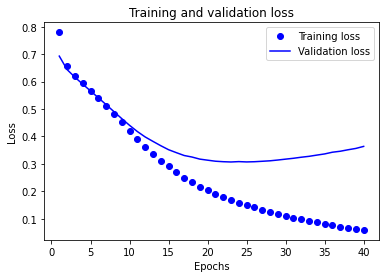

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

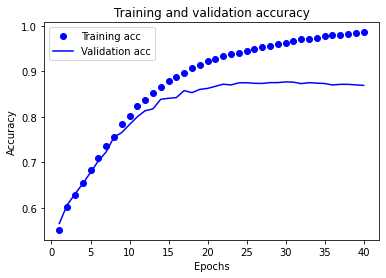

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.